# EDA y Preprocesamiento de Datos

## Objetivo

Este notebook es el primer paso en nuestro proyecto de clasificación de préstamos. Sus responsabilidades son:
1.  **Cargar** el conjunto de datos crudo de Lending Club.
2.  Realizar un **Análisis Exploratorio de Datos (EDA)** para entender las características, distribuciones y relaciones en los datos.
3.  **Limpiar y Preprocesar** los datos, creando la variable objetivo y preparando un subconjunto de características para el modelado.
4.  **Guardar** el DataFrame limpio en un formato eficiente (Parquet) para que pueda ser utilizado por los siguientes notebooks del pipeline.

-   **Entrada:** `../data/raw/accepted_2007_to_2018Q4.csv`
-   **Salida:** `../data/processed/loans_cleaned.parquet`

### 1. Importación de Librerías y Configuración

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Configuraciones de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

### 2. Definición de Rutas y Carga de Datos

In [27]:
# Definir las rutas relativas
RAW_DATA_PATH = 'data/raw/accepted.gz'
PROCESSED_DATA_PATH = 'data/processed/loans_cleaned.parquet'
PROCESSED_DIR = 'data/processed'

In [28]:
# Cargar el dataset
df_raw = pd.read_csv(RAW_DATA_PATH, low_memory=False)
print(f"Dataset cargado exitosamente.")
print(f"Dimensiones del dataset crudo: {df_raw.shape[0]} filas y {df_raw.shape[1]} columnas.")

Dataset cargado exitosamente.
Dimensiones del dataset crudo: 2260701 filas y 151 columnas.


In [29]:
df_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,...,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.00,Aug-2003,675.00,679.00,1.00,30.00,NaN,7.00,0.00,2765.00,29.70,13.00,w,0.00,0.00,4421.72,4421.72,3600.00,821.72,0.00,0.00,0.00,Jan-2019,122.67,NaN,...,4.00,7.00,0.00,0.00,0.00,3.00,76.90,0.00,0.00,0.00,178050.00,7746.00,2400.00,13734.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.00,Dec-1999,715.00,719.00,4.00,6.00,NaN,22.00,0.00,21470.00,19.20,38.00,w,0.00,0.00,25679.66,25679.66,24700.00,979.66,0.00,0.00,0.00,Jun-2016,926.35,NaN,...,5.00,22.00,0.00,0.00,0.00,2.00,97.40,7.70,0.00,0.00,314017.00,39475.00,79300.00,24667.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.00,20000.00,20000.00,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.00,Aug-2000,695.00,699.00,0.00,NaN,NaN,6.00,0.00,7869.00,56.20,18.00,w,0.00,0.00,22705.92,22705.92,20000.00,2705.92,0.00,0.00,0.00,Jun-2017,15813.30,NaN,...,3.00,6.00,0.00,0.00,0.00,0.00,100.00,50.00,0.00,0.00,218418.00,18696.00,6200.00,14877.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.00,35000.00,35000.00,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.00,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.00,Sep-2008,785.00,789.00,0.00,NaN,NaN,13.00,0.00,7802.00,11.60,17.00,w,15897.65,15897.65,31464.01,31464.01,19102.35,12361.66,0.00,0.00,0.00,Feb-2019,829.90,Apr-2019,...,5.00,13.00,0.00,0.00,0.00,1.00,100.00,0.00,0.00,0.00,381215.00,522

### 3. Creación de la Variable Objetivo y Filtrado Inicial

De acuerdo con los requisitos del proyecto, nos enfocaremos únicamente en los préstamos que han sido completamente pagados (`Fully Paid`) o que han entrado en incumplimiento (`Charged Off`). Crearemos nuestra variable objetivo binaria `default` a partir de esta información.

In [30]:
# Ver los posibles valores de 'loan_status'
print("Valores en 'loan_status':")
print(df_raw['loan_status'].value_counts())

# Filtrar para mantener solo los estados finales relevantes
df = df_raw[df_raw['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()

# Crear la variable objetivo 'default'
# 1 si es 'Charged Off' (incumplimiento), 0 si es 'Fully Paid'
df['default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

print(f"\nDimensiones del dataset después de filtrar: {df.shape[0]} filas y {df.shape[1]} columnas.")
print("\nMapeo de 'loan_status' a 'default':")
print(df[['loan_status', 'default']].head())

Valores en 'loan_status':
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

Dimensiones del dataset después de filtrar: 1345310 filas y 152 columnas.

Mapeo de 'loan_status' a 'default':
  loan_status  default
0  Fully Paid        0
1  Fully Paid        0
2  Fully Paid        0
4  Fully Paid        0
5  Fully Paid        0


### 4. Análisis Exploratorio de Datos (EDA)

#### 4.1. Distribución de la Variable Objetivo

Es crucial analizar el balance de clases. Un desbalance significativo puede requerir técnicas especiales durante el modelado.

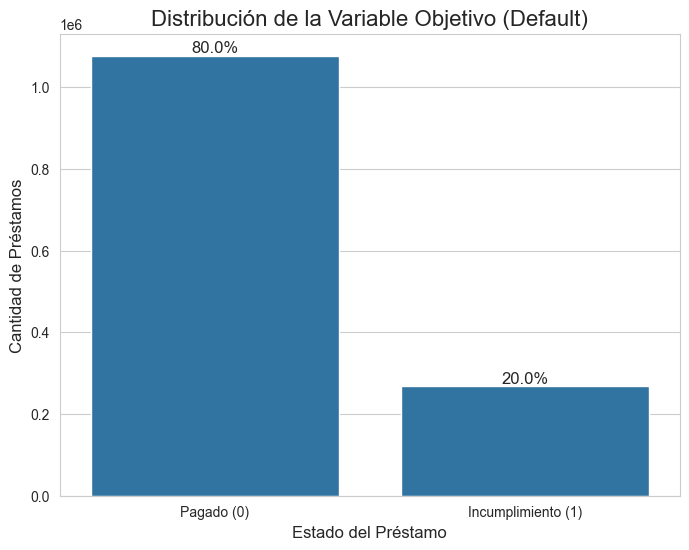

Balance de clases:
default
0   0.80
1   0.20
Name: proportion, dtype: float64


In [31]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='default', data=df)
plt.title('Distribución de la Variable Objetivo (Default)', fontsize=16)
plt.xlabel('Estado del Préstamo', fontsize=12)
plt.ylabel('Cantidad de Préstamos', fontsize=12)
plt.xticks([0, 1], ['Pagado (0)', 'Incumplimiento (1)'])

# Añadir porcentajes en las barras
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

print("Balance de clases:")
print(df['default'].value_counts(normalize=True))

Observamos un desbalance de clases, con aproximadamente un 80% de préstamos pagados y un 20% en incumplimiento. Esto es típico en problemas de riesgo crediticio.

#### 4.2. Selección de Características y Análisis de Nulos

Seleccionamos el subconjunto de características especificadas en el proyecto para el análisis y modelado.

In [32]:
selected_features = [
    'loan_amnt',       # Monto del préstamo
    'int_rate',        # Tasa de interés
    'fico_range_high', # Puntuación FICO (límite superior)
    'emp_length',      # Antigüedad laboral
    'annual_inc',      # Ingreso anual
    'purpose',         # Propósito del préstamo
    'home_ownership',  # Situación de la vivienda
    'dti',             # Ratio deuda-ingreso
    'addr_state',      # Estado de residencia
    'default'          # Nuestra variable objetivo
]

df_subset = df[selected_features].copy()

print("Información del subset de datos:")
df_subset.info()

print("\nPorcentaje de valores faltantes por columna:")
missing_percentage = (df_subset.isnull().sum() / len(df_subset) * 100).sort_values(ascending=False)
print(missing_percentage[missing_percentage > 0])

Información del subset de datos:
<class 'pandas.core.frame.DataFrame'>
Index: 1345310 entries, 0 to 2260697
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   loan_amnt        1345310 non-null  float64
 1   int_rate         1345310 non-null  float64
 2   fico_range_high  1345310 non-null  float64
 3   emp_length       1266799 non-null  object 
 4   annual_inc       1345310 non-null  float64
 5   purpose          1345310 non-null  object 
 6   home_ownership   1345310 non-null  object 
 7   dti              1344936 non-null  float64
 8   addr_state       1345310 non-null  object 
 9   default          1345310 non-null  int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 112.9+ MB

Porcentaje de valores faltantes por columna:
emp_length   5.84
dti          0.03
dtype: float64


Las columnas `emp_length` y `dti` tienen valores faltantes. Estos deberán ser manejados (imputados) antes del modelado.

#### 4.3. Limpieza de Características

La columna `emp_length` es categórica y necesita ser convertida a un formato numérico.

In [33]:
def clean_emp_length(x):
    if pd.isna(x) or x == 'n/a':
        return np.nan # Mantenemos el NaN para imputarlo después
    elif x == '< 1 year':
        return 0
    elif x == '10+ years':
        return 10
    else:
        # Extrae el número usando una expresión regular
        return int(re.findall(r'\d+', x)[0])

print("Valores originales de 'emp_length':")
print(df_subset['emp_length'].value_counts(dropna=False).sort_index())

df_subset['emp_length'] = df_subset['emp_length'].apply(clean_emp_length)

print("\nValores de 'emp_length' después de la limpieza:")
print(df_subset['emp_length'].value_counts(dropna=False).sort_index())

Valores originales de 'emp_length':
emp_length
1 year        88494
10+ years    442199
2 years      121743
3 years      107597
4 years       80556
5 years       84154
6 years       62733
7 years       59624
8 years       60701
9 years       50937
< 1 year     108061
NaN           78511
Name: count, dtype: int64

Valores de 'emp_length' después de la limpieza:
emp_length
0.00     108061
1.00      88494
2.00     121743
3.00     107597
4.00      80556
5.00      84154
6.00      62733
7.00      59624
8.00      60701
9.00      50937
10.00    442199
NaN       78511
Name: count, dtype: int64


#### 4.4. Visualizaciones de Características

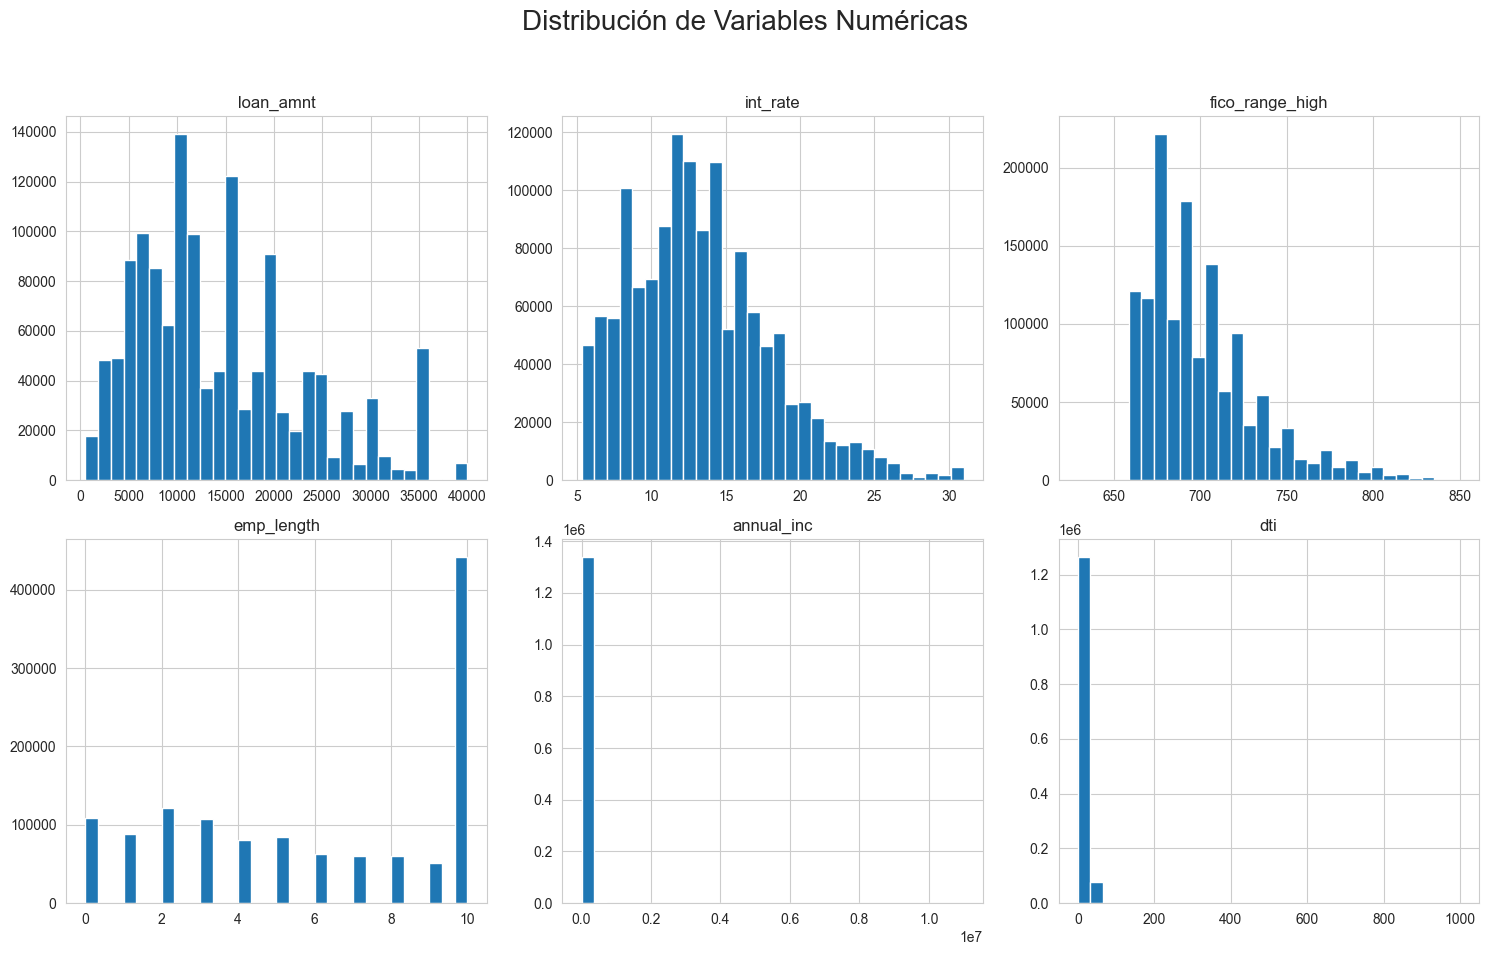

In [34]:
numerical_cols = df_subset.select_dtypes(include=np.number).columns.drop('default').tolist()
categorical_cols = df_subset.select_dtypes(exclude=np.number).columns.tolist()

# Histogramas de variables numéricas
df_subset[numerical_cols].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribución de Variables Numéricas', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

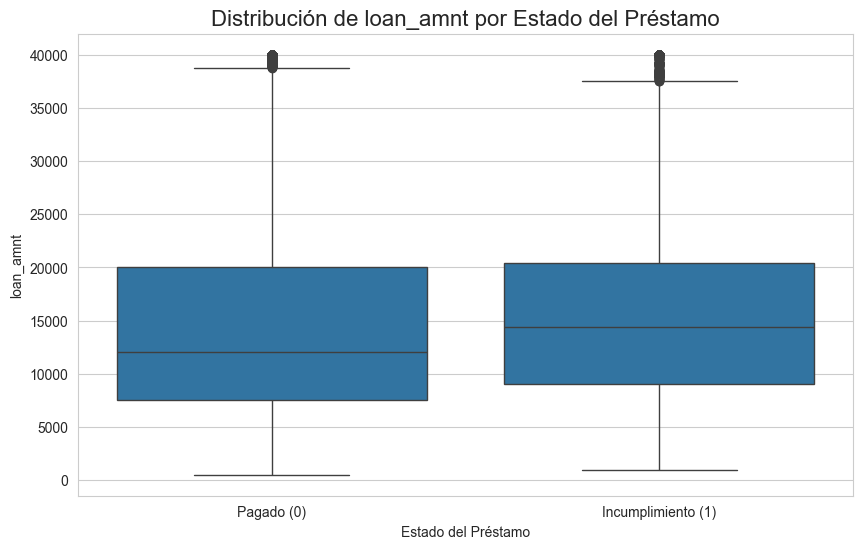

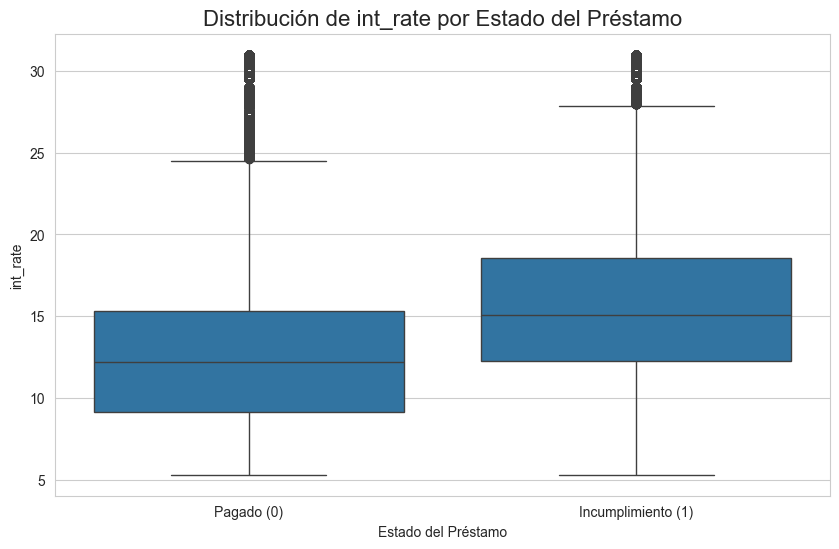

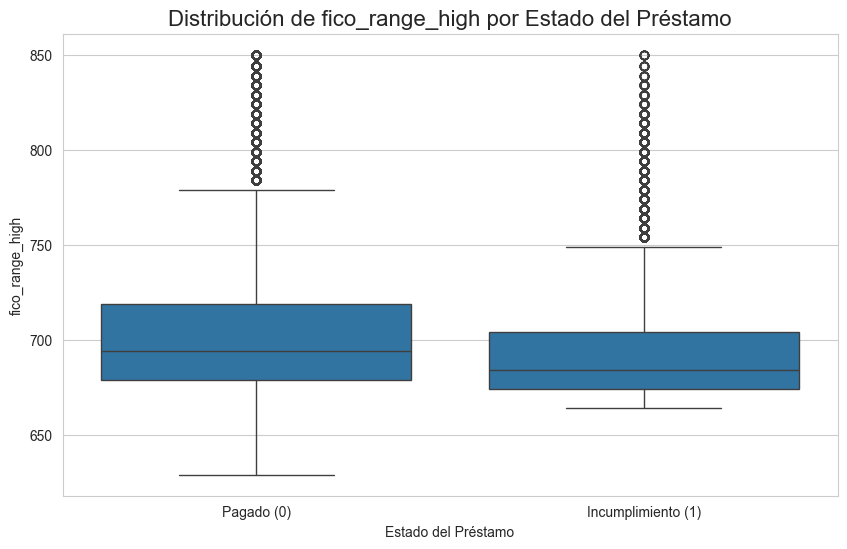

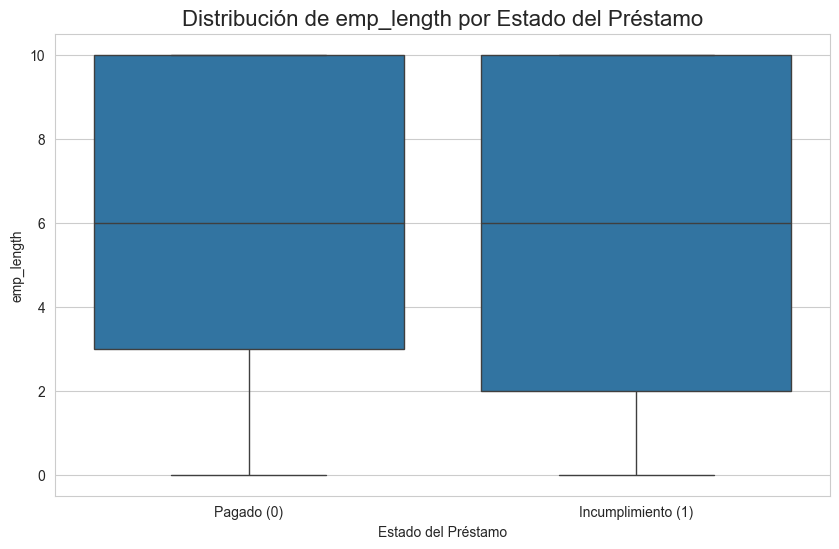

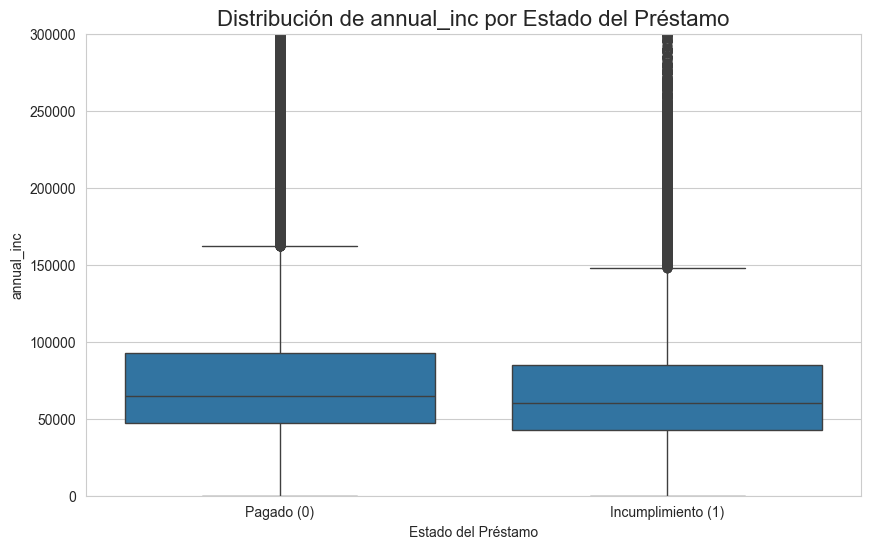

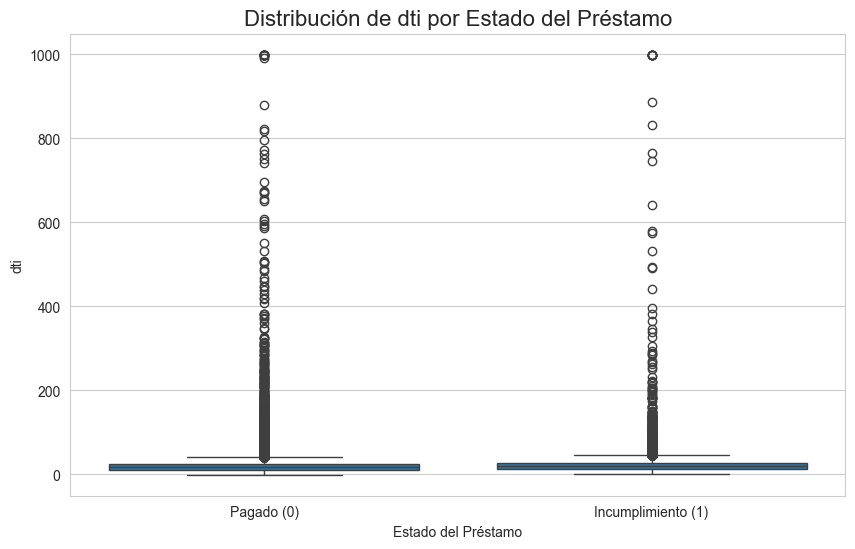

In [35]:
# Boxplots de variables numéricas por clase de 'default'
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='default', y=col, data=df_subset)
    plt.title(f'Distribución de {col} por Estado del Préstamo', fontsize=16)
    plt.xticks([0, 1], ['Pagado (0)', 'Incumplimiento (1)'])
    plt.xlabel('Estado del Préstamo')
    plt.ylabel(col)
    # Limitar outliers en 'annual_inc' para una mejor visualización
    if col == 'annual_inc':
        plt.ylim(0, 300000) 
    plt.show()

**Observaciones de los Boxplots:**
-   `int_rate`: Las tasas de interés son notablemente más altas para los préstamos en incumplimiento.
-   `fico_range_high`: Las puntuaciones FICO son más bajas para los prestatarios que incumplen.
-   `dti`: El ratio deuda-ingreso tiende a ser ligeramente mayor en los casos de incumplimiento.
-   `loan_amnt`: Los montos de los préstamos en incumplimiento parecen ser un poco más altos.

#### 4.5. Análisis de Correlación

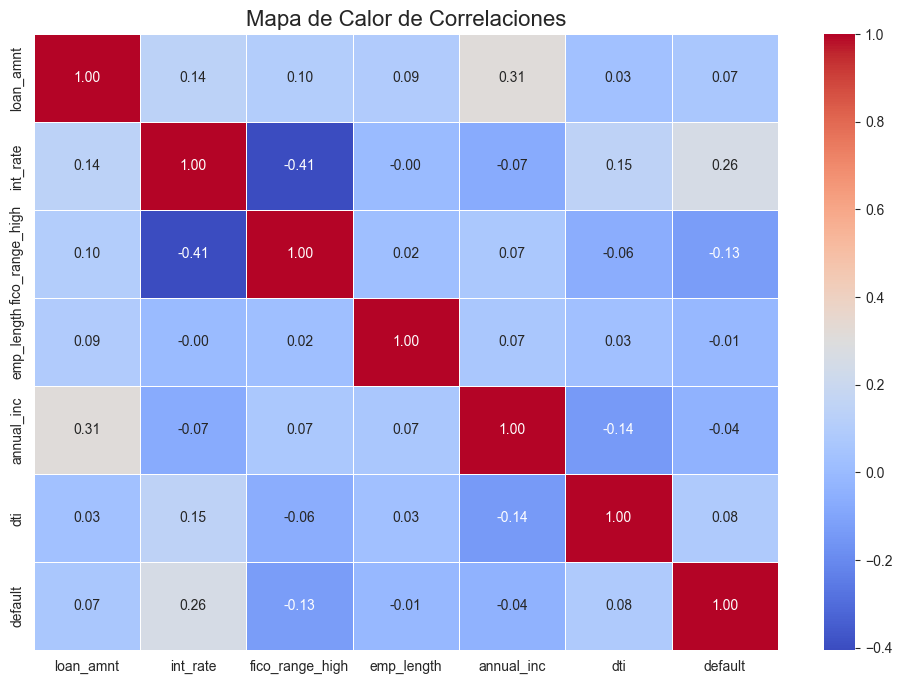

In [36]:
plt.figure(figsize=(12, 8))
corr = df_subset[numerical_cols + ['default']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Correlaciones', fontsize=16)
plt.show()

**Observaciones de la Correlación:**
-   La correlación más fuerte con `default` es `int_rate` (positiva, 0.26) y `fico_range_high` (negativa, -0.29), lo cual confirma nuestras observaciones de los boxplots.
-   Existe una correlación moderada entre `loan_amnt` y `annual_inc`, lo cual es lógico (mayores ingresos permiten mayores préstamos).

### 5. Guardado del DataFrame Procesado

Finalmente, guardamos el `df_subset` limpio y preprocesado en formato Parquet. Este archivo será la entrada para los notebooks de modelado.

In [37]:
df_subset.to_parquet(PROCESSED_DATA_PATH, index=False)
print(f"DataFrame procesado guardado exitosamente en:\n{PROCESSED_DATA_PATH}")
print(f"\nDimensiones finales del DataFrame guardado: {df_subset.shape}")
print("\nPrimeras 5 filas del DataFrame final:")
print(df_subset.head())

DataFrame procesado guardado exitosamente en:
data/processed/loans_cleaned.parquet

Dimensiones finales del DataFrame guardado: (1345310, 10)

Primeras 5 filas del DataFrame final:
   loan_amnt  int_rate  fico_range_high  emp_length  annual_inc  \
0    3600.00     13.99           679.00       10.00    55000.00   
1   24700.00     11.99           719.00       10.00    65000.00   
2   20000.00     10.78           699.00       10.00    63000.00   
4   10400.00     22.45           699.00        3.00   104433.00   
5   11950.00     13.44           694.00        4.00    34000.00   

              purpose home_ownership   dti addr_state  default  
0  debt_consolidation       MORTGAGE  5.91         PA        0  
1      small_business       MORTGAGE 16.06         SD        0  
2    home_improvement       MORTGAGE 10.78         IL        0  
4      major_purchase       MORTGAGE 25.37         PA        0  
5  debt_consolidation           RENT 10.20         GA        0  


---
### Fin del Notebook 1

Hemos completado el análisis exploratorio y la preparación inicial de los datos. El dataset está ahora limpio y listo para ser utilizado en los siguientes pasos de modelado con Scikit-learn y PySpark.
---